In [ ]:
!pip install geopandas matplotlib scipy
!pip install seaborn
!pip install contextily
!pip install pointpats
!pip install matplotlib-scalebar
!pip install folium
!pip install pysal
!pip install tabulate

# Import Packages

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

# for maps
import contextily as ctx
import matplotlib_scalebar as scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import rasterio
import folium

from scipy.stats import gaussian_kde

from scipy.spatial import cKDTree
#import spatstat as sp

import pointpats
from pointpats import PoissonPointProcess, PoissonClusterPointProcess, Window, poly_from_bbox, PointPattern

import shapely
from shapely.geometry import MultiPolygon
from shapely.geometry import Point
from shapely.geometry import box

import libpysal as ps
from libpysal.cg import shapely_ext

from tabulate import tabulate

## Importing Geospatial Files

In [3]:
# Read the GeoJSON file containing the Colorado border
colorado_border = gpd.read_file('Shapefiles/Colorado_State_Boundary.geojson')

# Reproject to EPSG:26913 and check
colorado_border = colorado_border.to_crs(epsg=26913)
print("Colorado Border - New Coordinate Reference System (CRS):", colorado_border.crs)

#Read coal fires shapefile
coal_fires = gpd.read_file('Shapefiles/CO_AML_Mine_Fire_Locations.shp')
print("Coal Fires - Old Coordinate Reference System (CRS):", coal_fires.crs)

# Read coal mine location shapefile
coal_mines = gpd.read_file('Shapefiles/coal_mines.shp')
coal_mines = coal_mines.to_crs(epsg=26913)
print("Coal Mines New Coordinate Reference System (CRS):", coal_mines.crs)

co_geology = gpd.read_file('Shapefiles/CO_Geology_Polygons.shp')
co_geology = co_geology.to_crs(epsg=26913)
print("Colorado GeologyNew Coordinate Reference System (CRS):", co_geology.crs)

co_coal = gpd.read_file('Shapefiles/CO_Geology_Polygons_coal.shp')
co_coal = co_coal.to_crs(epsg=26913)
print("Colorado Coal New Coordinate Reference System (CRS):", co_coal.crs)

# Read coal geology units with alluvium removed, generated in ArcGIS Pro
coal_fill = gpd.read_file('Shapefiles/CO_Geology_Polygons_coal_fill.shp')
coal_fill = coal_fill.to_crs(epsg=26913)
print("Colorado Coal Fill New Coordinate Reference System (CRS):", coal_fill.crs)

# Read coal regions
coal_regions = gpd.read_file('Shapefiles/coal_regions.shp')
coal_regions = coal_regions.to_crs(epsg=26913)
print("Coal Regions - New Coordinate Reference System (CRS):", coal_regions.crs)
# Drop empty polygons
coal_regions = coal_regions[~(coal_regions['NAME'].str.contains('None', case=False))]

# Read interstate file used for mapping
interstates = gpd.read_file('Shapefiles/Interstate/CO_Interstate_RefernceMap.shp')
interstates = interstates.to_crs(epsg=26913)
print("Interstates - New Coordinate Reference System (CRS):", interstates.crs)

Colorado Border - New Coordinate Reference System (CRS): EPSG:26913
Coal Fires - Old Coordinate Reference System (CRS): EPSG:26913
Coal Mines New Coordinate Reference System (CRS): EPSG:26913
Colorado GeologyNew Coordinate Reference System (CRS): EPSG:26913
Colorado Coal New Coordinate Reference System (CRS): EPSG:26913
Colorado Coal Fill New Coordinate Reference System (CRS): EPSG:26913
Coal Regions - New Coordinate Reference System (CRS): EPSG:26913
Interstates - New Coordinate Reference System (CRS): EPSG:26913


# Background plots

/tmp/ipykernel_423/3855292265.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


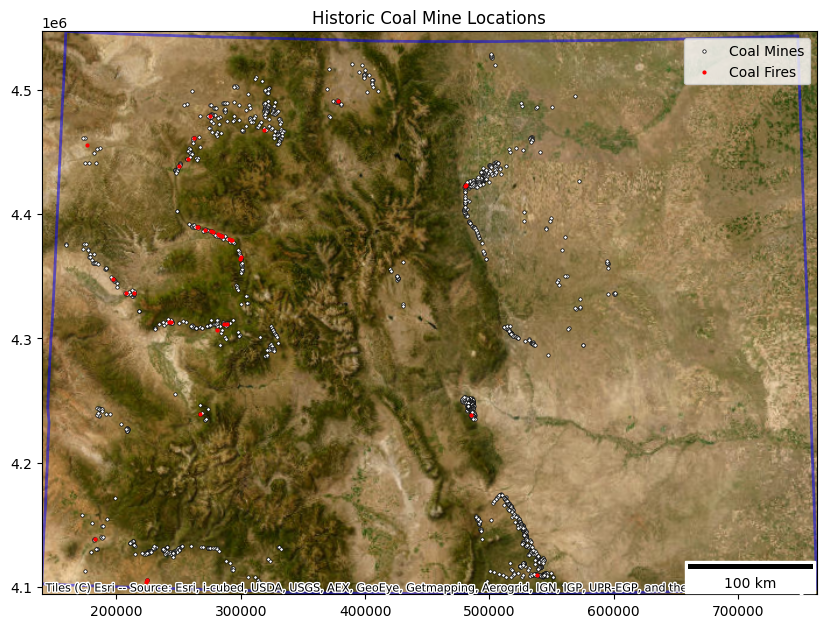

In [40]:
# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the points on the axis
coal_mines.plot(ax=ax, color='white', edgecolor='black', markersize=6, linewidth=0.5, label='Coal Mines')
coal_fires.plot(ax=ax, color='red', edgecolor='red', markersize=4, linewidth=1, label='Coal Fires')

# Add basemap using contextily
ctx.add_basemap(ax=ax, crs=coal_mines.crs.to_string(), source=ctx.providers.Esri.WorldImagery)

# Plot the Colorado border
colorado_border.plot(ax=ax, edgecolor='blue', linewidth=2, alpha=0.5, facecolor='none', label='Colorado Border')

# Get the bounding box of the Colorado border and set extent
minx, miny, maxx, maxy = colorado_border.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add scale bar
scalebar = ScaleBar(1, units='m', location='lower right')  # 1 pixel = 1 meter
ax.add_artist(scalebar)

# Set title and show the plot
plt.title('Historic Coal Mine Locations')
plt.legend()
plt.show()

In [41]:
print(type(coal_mines))
print(len(coal_mines))
print(coal_mines['COALREGION'].unique())
coal_mines.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
1573
['Raton Mesa' 'Canon City' 'San Juan River' 'Uinta' 'Denver' 'Green River'
 'North Park' 'South Park']


ID     PRIME_MINE                          OPERATOR     SEC1_MINE  \
0   25        Berwind             C.F. and I. 1892-1928          None   
1  812  Canon Quality  Canon Quality Coal Co, 1940-1942          None   
2   96    Deer Canyon  No operator given, no date given          None   
3  639       Gadberry             RV Gadberry 1925-1930          Hunt   
4  642         Garcia        Simon B. Garcia, 1948-1956  Garcia Strip   

                 SEC1_OPER SEC2_MINE SEC2_OPER      COALREGION   COALFIELD  \
0                     None      None      None      Raton Mesa    Trinidad   
1                     None      None      None      Canon City  Canon City   
2                     None      None      None      Raton Mesa    Trinidad   
3     EO Oliver, 1928-1946      None      None  San Juan River     Durango   
4  Garcia and Mackey, 1953      None      None  San Juan River     Durango   

              AREA  ... DIFFEREN_3     PROD_3 DIFFEREN_4     PROD_4  \
0             None  ...  T31S R65W  2243263.0  T32S R65W  2243263.0   
1             None  ...       None        0.0       None        0.0   
2             None  ...       None        0.0       None        0.0   
3          Durango  ...       None        0.0       None        0.0   
4  Pagosa Junction  ...       None        0.0       None        0.0   

   TOTAL_PROD RECOVERY%   DEPLETION    X    Y                        geometry  
0   9973052.0      50.0  19946104.0  0.0  0.0  POINT (535339.717 4126855.626)  
1     12001.0      50.0     24002.0  0.0  0.0  POINT (486824.001 4237745.974)  
2         0.0       NaN         NaN  0.0  0.0  POINT (531664.322 4126189.746)  
3     13479.0      50.0     26958.0  0.0  0.0  POINT (226780.594 4128571.608)  
4      1578.0      50.0      3156.0  0.0  0.0  POINT (311526.662 4108191.087)  

[5 rows x 58 columns]

In [43]:
coal_regions.head()

AREA      PERIMETER  COAL_REGIO  COAL_REG_1  GRID_CODE  \
1  8.274462e+09  635484.996507           3           0          0   
2  4.657869e+09  313713.089556           4           0          0   
3  2.763420e+09  503775.633420           5           0          0   
4  3.288186e+07   42861.833961           6           0          0   
5  7.652127e+06   15134.514463           7           0          0   

                 NAME                                           geometry  
1  Green River Region  POLYGON ((188307.317 4545385.725, 188667.977 4...  
2       Denver Region  POLYGON ((596292.212 4539582.198, 596291.084 4...  
3   North Park Region  POLYGON ((392553.462 4522099.032, 392638.056 4...  
4   North Park Region  POLYGON ((402345.253 4508507.296, 402260.649 4...  
5   North Park Region  POLYGON ((413302.640 4490227.838, 413217.523 4...

## Clip Mine and Fire Data to Study Area

/tmp/ipykernel_423/4018790071.py:21: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


<function matplotlib.pyplot.show(close=None, block=None)>

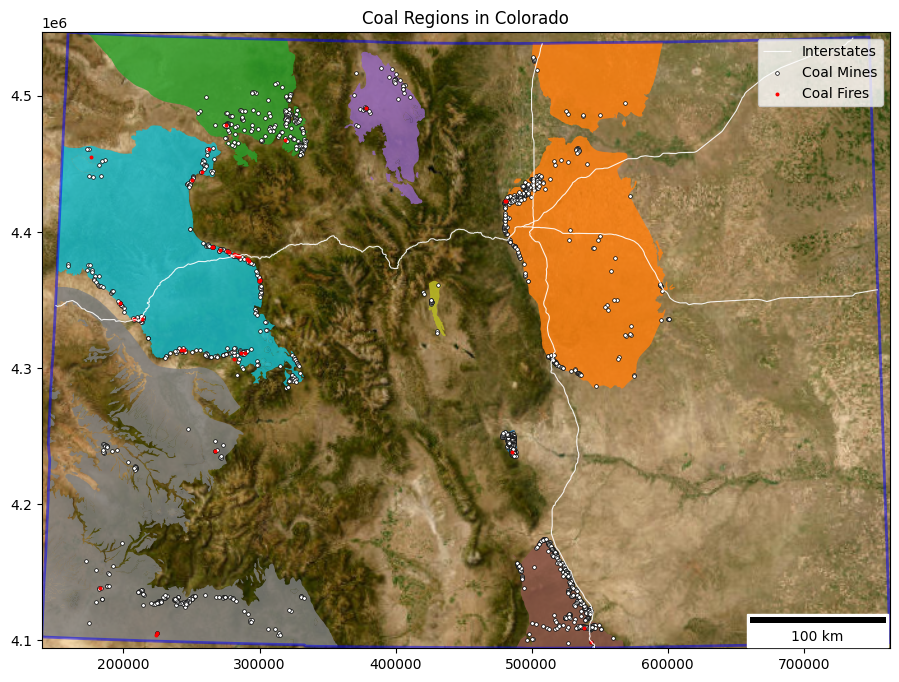

In [149]:
fig, ax = plt.subplots(figsize=(12, 8))

coal_regions.plot(ax=ax, column="NAME", alpha = 0.1, label='Coal Regions')
interstates.plot(ax=ax, color= 'white', edgecolor='black', alpha = 0.9, linewidth=0.8, label='Interstates')
coal_regions.plot(ax=ax, column="NAME", alpha = 0.8)
coal_mines.plot(ax=ax, color='white', edgecolor='black', markersize=7, linewidth=0.5, label='Coal Mines')
coal_fires.plot(ax=ax, color='red', edgecolor='black', markersize=8, linewidth=0.01, label='Coal Fires')
ctx.add_basemap(ax=ax, crs=coal_mines.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution = '')

# Plot the Colorado border
colorado_border.plot(ax=ax, edgecolor='blue', linewidth=2, alpha=0.5, facecolor='none', label='Colorado Border')

# Get the bounding box of the Colorado border and set extent
minx, miny, maxx, maxy = colorado_border.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

scalebar = ScaleBar(1, units='m', location='lower right')  # 1 pixel = 1 meter
ax.add_artist(scalebar)

plt.legend()
plt.title('Coal Regions in Colorado')
plt.show

Coal Regions - Old Coordinate Reference System (CRS): EPSG:4326
Coal Regions New Coordinate Reference System (CRS): EPSG:26913


/tmp/ipykernel_423/2109811456.py:22: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


<function matplotlib.pyplot.show(close=None, block=None)>

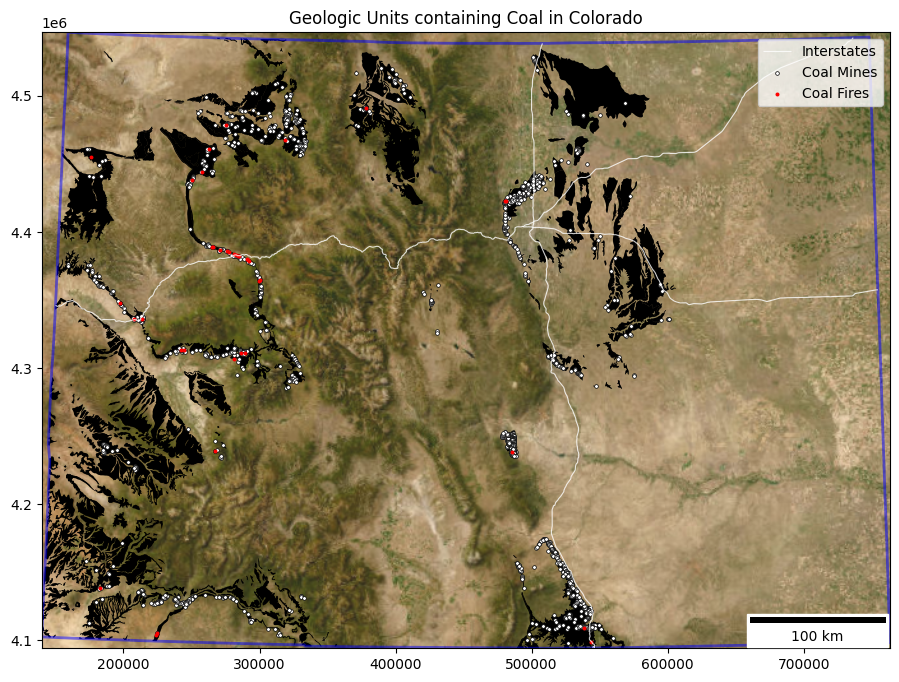

In [158]:
fig, ax = plt.subplots(figsize=(12, 8))

#coal_regions.plot(ax=ax, column="NAME", edgecolor='black', alpha = 0.8, label='Coal Regions')
coal_fill.plot(ax=ax, color='black')
interstates.plot(ax=ax, color= 'white', edgecolor='black', alpha = 0.8, linewidth=0.8, label='Interstates')
coal_fill.plot(ax=ax, color='black', alpha=0.6)
coal_mines.plot(ax=ax, color='white', edgecolor='black', markersize=7, linewidth=0.5, label='Coal Mines')
coal_fires.plot(ax=ax, color='red', edgecolor='black', markersize=8, linewidth=0.01, label='Coal Fires')
ctx.add_basemap(ax=ax, crs=coal_mines.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution = '', alpha=0.9)

# Plot the Colorado border
colorado_border.plot(ax=ax, edgecolor='blue', linewidth=2, alpha=0.5, facecolor='none', label='Colorado Border')

# Get the bounding box of the Colorado border and set extent
minx, miny, maxx, maxy = colorado_border.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

scalebar = ScaleBar(1, units='m', location='lower right')  # 1 pixel = 1 meter
ax.add_artist(scalebar)

plt.legend()
plt.title('Geologic Units containing Coal in Colorado')
plt.show

In [46]:
union_geo_coal = coal_fill.unary_union
coal_merge = gpd.GeoDataFrame(geometry = gpd.GeoSeries(union_geo_coal), crs=coal_fill.crs)
print(type(coal_merge))

<class 'geopandas.geodataframe.GeoDataFrame'>


/tmp/ipykernel_423/40763310.py:21: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


<function matplotlib.pyplot.show(close=None, block=None)>

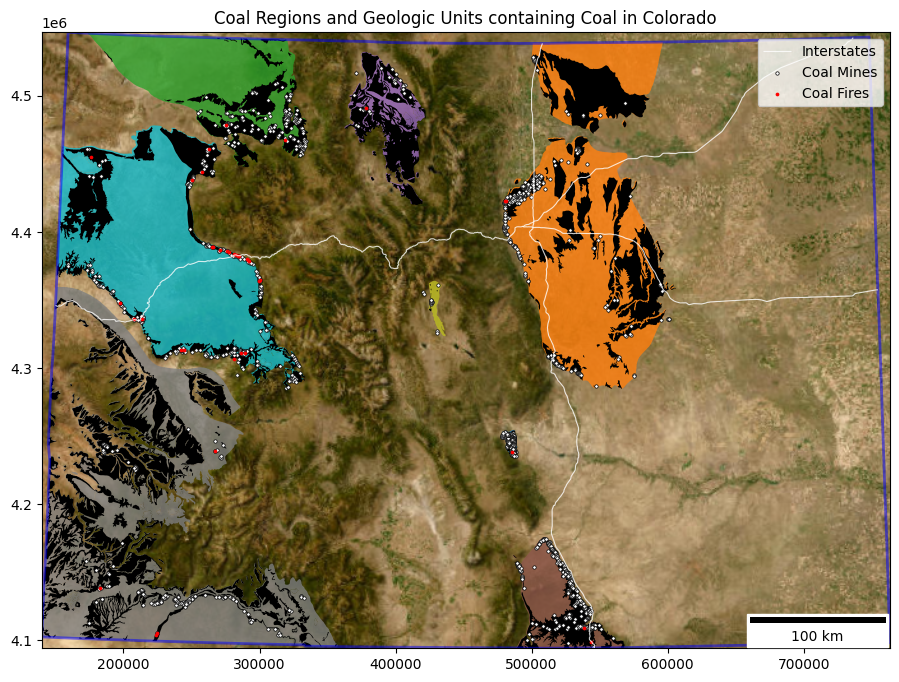

In [159]:
fig, ax = plt.subplots(figsize=(12, 8))

coal_regions.plot(ax=ax, column="NAME", alpha = 0.8, label='Coal Regions')
coal_merge.plot(ax=ax, color='black')
interstates.plot(ax=ax, color= 'white', edgecolor='black', alpha = 0.8, linewidth=0.8, label='Interstates')
coal_mines.plot(ax=ax, color='white', edgecolor='black', markersize=6, linewidth=0.5, label='Coal Mines')
coal_fires.plot(ax=ax, color='red', edgecolor='black', markersize=7, linewidth=0.01, label='Coal Fires')
ctx.add_basemap(ax=ax, crs=coal_mines.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution = '')

# Plot the Colorado border
colorado_border.plot(ax=ax, edgecolor='blue', linewidth=2, alpha=0.5, facecolor='none', label='Colorado Border')

# Get the bounding box of the Colorado border and set extent
minx, miny, maxx, maxy = colorado_border.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

scalebar = ScaleBar(1, units='m', location='lower right')  # 1 pixel = 1 meter
ax.add_artist(scalebar)

plt.legend()
plt.title('Coal Regions and Geologic Units containing Coal in Colorado')
plt.show

Buffer Distance      Mines Inside Buffer  Percentage of Mines Within      Fires Inside Buffer  Percentage of Fires Within
-----------------  ---------------------  ----------------------------  ---------------------  ----------------------------
0ft                                 1302  82.77%                                           33  86.84%
500ft                               1406  89.38%                                           35  92.11%
1000ft                              1458  92.69%                                           36  94.74%
1500ft                              1492  94.85%                                           37  97.37%
2000ft                              1506  95.74%                                           37  97.37%
2500ft                              1520  96.63%                                           37  97.37%
3000ft                              1526  97.01%                                           37  97.37%
3500ft                              1531

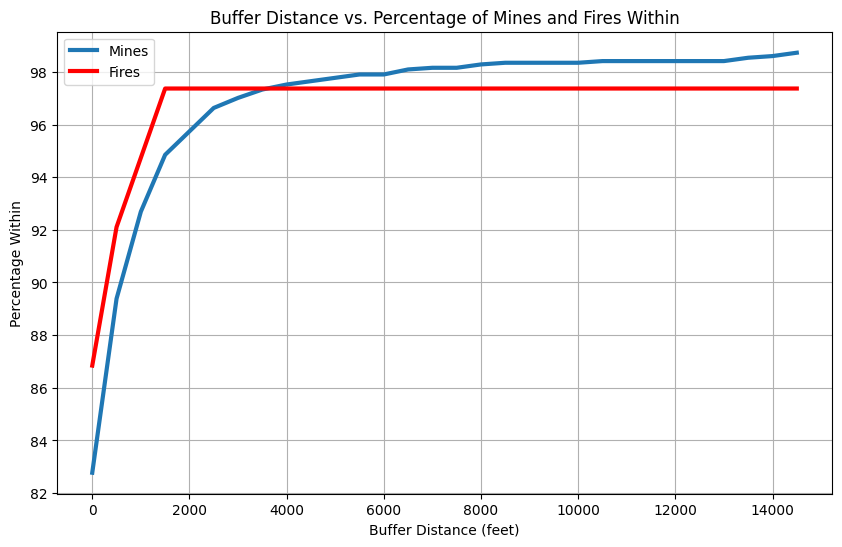

In [80]:
buffer_distances_feet = range(0, 15000, 500)  # Range from 0 to 1000 in steps of 500

# Initialize dictionaries to store results
buffer = {}
mines_results = {}
fires_results = {}
mines_percentage_within = {}
fires_percentage_within = {}

# Calculate total number of mine points
total_mines = len(coal_mines)
total_fires = len(coal_fires)

# Initialize a list to store table rows
buffer_data = []

# Iterate over buffer distances in feet
for distance_feet in buffer_distances_feet:
    # Convert feet to meters
    distance_meters = distance_feet * 0.3048  # 1 foot = 0.3048 meters
    #buffer_distance[distance_feet] = distance_feet
    
    # Calculate buffer
    coal_buffer = coal_merge.buffer(distance_meters)
    coal_buffer_gdf = gpd.GeoDataFrame(geometry=coal_buffer)
    buffer[distance_feet] = coal_buffer_gdf
    
    # Spatial join coal mines with buffer
    mines_in_buff = gpd.sjoin(coal_mines, coal_buffer_gdf, predicate='within')
    
    # Calculate percentage of mines within the buffer
    percentage_within_mines = (len(mines_in_buff) / total_mines) * 100
    
    # Store results in dictionaries
    mines_results[distance_feet] = {'mines_in_buff': mines_in_buff}
    mines_percentage_within[distance_feet] = percentage_within_mines

    # Spatial join coal fires with buffer
    fires_in_buff = gpd.sjoin(coal_fires, coal_buffer_gdf, predicate='within')
    
    # Calculate percentage of fires within the buffer
    percentage_within_fires = (len(fires_in_buff) / total_fires) * 100
    
    # Store results in dictionaries
    fires_results[distance_feet] = {'fires_in_buff': fires_in_buff}
    fires_percentage_within[distance_feet] = percentage_within_fires
    
    # Append row to the table
    buffer_data.append([f"{distance_feet}ft", len(mines_in_buff), f"{percentage_within_mines:.2f}%", len(fires_in_buff), f"{percentage_within_fires:.2f}%"])

# Print results in table format
print(tabulate(buffer_data, headers=["Buffer Distance", "Mines Inside Buffer", "Percentage of Mines Within", "Fires Inside Buffer", "Percentage of Fires Within"]))

# Extract distances and percentages
distances = list(mines_percentage_within.keys())
mine_percentages = [mines_percentage_within[distance] for distance in distances]
fire_percentages = [fires_percentage_within[distance] for distance in distances]

# Plot graph
plt.figure(figsize=(10, 6))
plt.plot(distances, mine_percentages, linestyle='-', linewidth=3, label='Mines')
plt.plot(distances, fire_percentages, color = 'red', linestyle='-', linewidth=3, label='Fires')
plt.xlabel('Buffer Distance (feet)')
plt.ylabel('Percentage Within')
plt.title('Buffer Distance vs. Percentage of Mines and Fires Within')
plt.legend()
plt.grid(True)
plt.show()

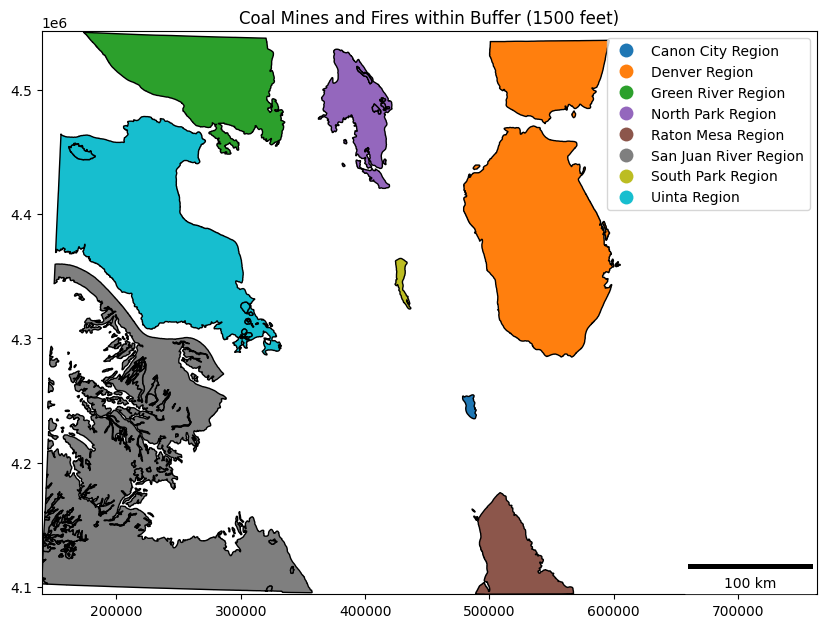

In [174]:
# Selecting the buffer output for a specific distance (e.g., 10560 feet)
selected_distance_feet = 1500

selected_mines_in_buff = mines_results[selected_distance_feet]['mines_in_buff']
selected_fires_in_buff = fires_results[selected_distance_feet]['fires_in_buff']
selected_buff = buffer[selected_distance_feet]

# Plotting the selected buffer outputs on a map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot coal regions
coal_regions.plot(ax=ax, column="NAME", edgecolor='black', legend=True)
#selected_buff.plot(ax=ax, color='black')
#selected_mines_in_buff.plot(ax=ax, color='white', edgecolor='black', markersize=6, linewidth=0.5, label='Mines within Buffer')

#selected_fires_in_buff.plot(ax=ax, color='red', edgecolor='black', markersize=7, linewidth=0.01, label='Fires within Buffer')

#ctx.add_basemap(ax=ax, crs=coal_mines.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution = '')

#colorado_border.plot(ax=ax, edgecolor='blue', linewidth=2, alpha=0.5, facecolor='none', label='Colorado Border')

# Get the bounding box of the Colorado border and set extent
minx, miny, maxx, maxy = colorado_border.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

scalebar = ScaleBar(1, units='m', location='lower right')  # 1 pixel = 1 meter
ax.add_artist(scalebar)

#plt.legend()

# Set title
plt.title('Coal Mines and Fires within Buffer (1500 feet)')
plt.show()

# 1st Order Effects
## KDE

/tmp/ipykernel_423/3626267325.py:35: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


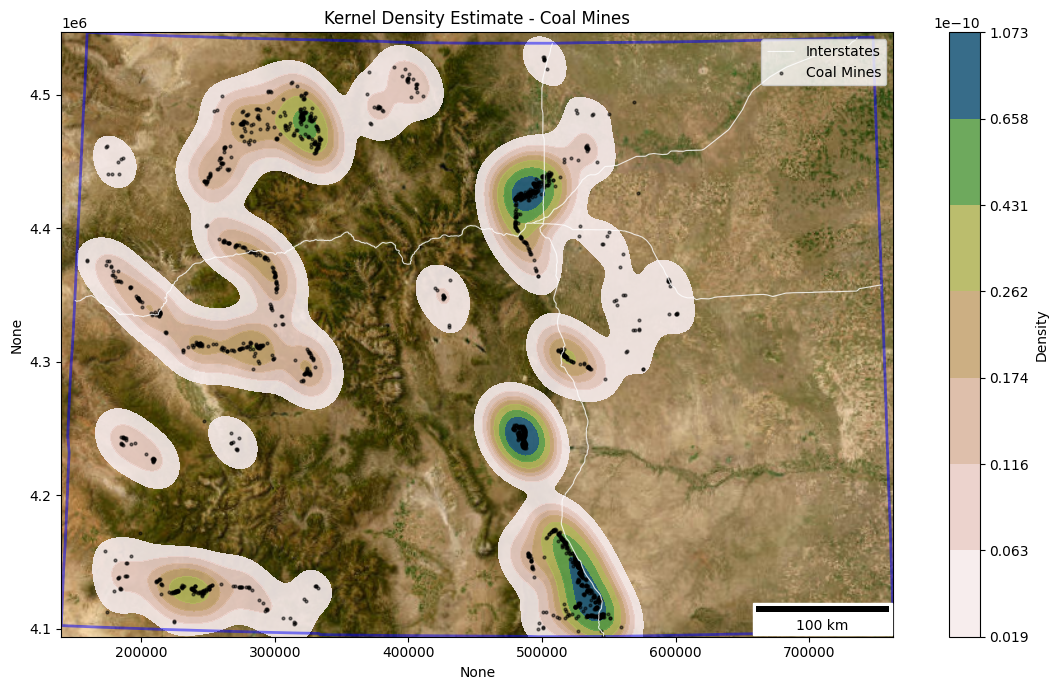

In [162]:
data = coal_mines
x = data.geometry.x
y = data.geometry.y

# Create plot
f, ax = plt.subplots(ncols=1, figsize=(12, 7))

# Kernel Density Estimation
kde = sns.kdeplot(ax=ax, x=data['geometry'].x, y=data['geometry'].y,
    levels = 8,
    fill=True,
    cmap=plt.cm.gist_earth_r,
    bw_method=0.1,
    alpha=0.9)

# Add a basemap
ctx.add_basemap(ax=ax, crs=coal_mines.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution = '')
interstates.plot(ax=ax, color= 'white', edgecolor='black', alpha = 0.8, linewidth=0.8, label='Interstates')

colorado_border.plot(ax=ax, edgecolor='blue', linewidth=2, alpha=0.5, facecolor='none', label='Colorado Border')

# Get the bounding box of the Colorado border and set extent
minx, miny, maxx, maxy = colorado_border.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add scale bar
scalebar = ScaleBar(1, units='m', location='lower right')  # 1 pixel = 1 meter
ax.add_artist(scalebar)

plt.scatter(x, y, color='black', s=4, alpha=0.5, label = 'Coal Mines')

cbar = plt.colorbar(kde.collections[0], ax=ax, orientation='vertical')
cbar.set_label('Density')
plt.legend()
plt.title('Kernel Density Estimate - Coal Mines')
#ax.set_axis_off()
plt.tight_layout()

plt.show()

/tmp/ipykernel_423/1485558282.py:32: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


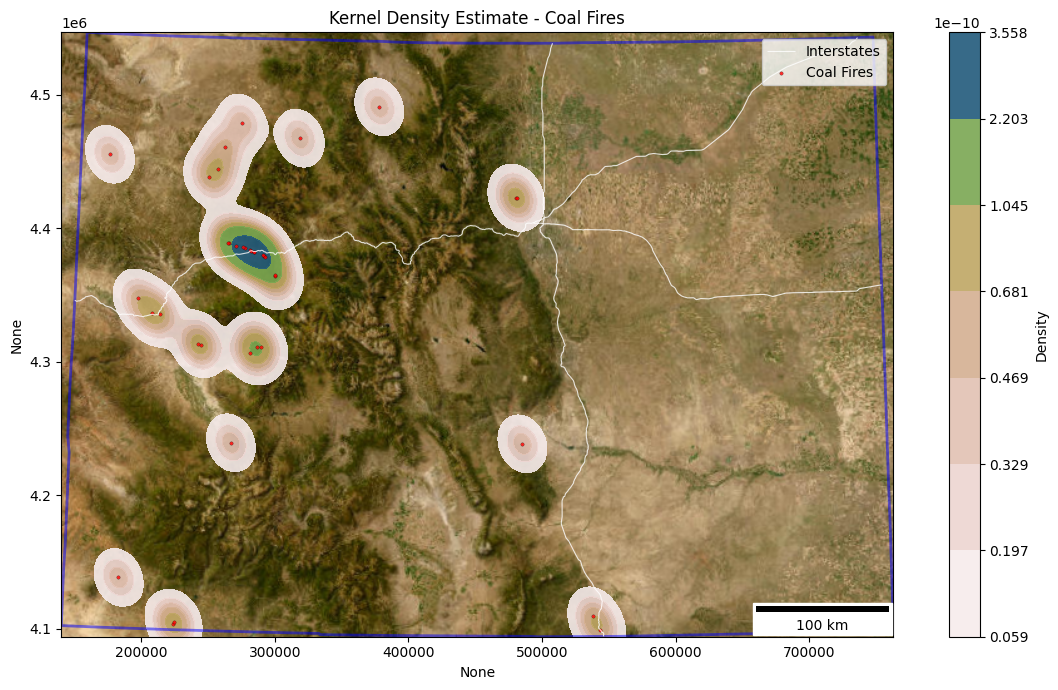

In [168]:
data = coal_fires
x = data.geometry.x
y = data.geometry.y

# Create plot
f, ax = plt.subplots(ncols=1, figsize=(12, 7))

# Kernel Density Estimation
kde = sns.kdeplot(ax=ax, x=data['geometry'].x, y=data['geometry'].y,
    levels = 8,
    fill=True,
    cmap=plt.cm.gist_earth_r,
    bw_method=0.1,
    alpha=0.9)

colorado_border.plot(ax=ax, edgecolor='blue', linewidth=2, alpha=0.5, facecolor='none', label='Colorado Border')
ctx.add_basemap(ax=ax, crs=coal_mines.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution = '')
interstates.plot(ax=ax, color= 'white', edgecolor='black', alpha = 0.8, linewidth=0.8, label='Interstates')

minx, miny, maxx, maxy = colorado_border.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add scale bar
scalebar = ScaleBar(1, units='m', location='lower right')  # 1 pixel = 1 meter
ax.add_artist(scalebar)

plt.scatter(x, y, color='red', edgecolor = 'black', linewidth=0.2, s=6, alpha=0.8, label = 'Coal Fires')

cbar = plt.colorbar(kde.collections[0], ax=ax, orientation='vertical')
cbar.set_label('Density')
plt.legend()
plt.title('Kernel Density Estimate - Coal Fires')
#ax.set_axis_off()
plt.tight_layout()

plt.show()

# 2nd Order Effects


## NND

Mean nearest neighbors distance: 970.3457564239693


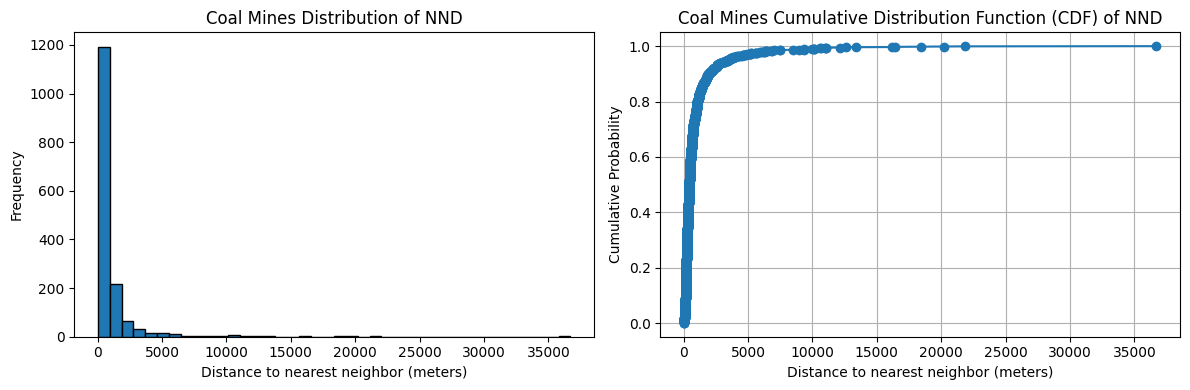

In [52]:
data = coal_mines
x = data.geometry.x
y = data.geometry.y

# Build a k-d tree from the point coordinates
tree = cKDTree(np.column_stack((x, y)))

# Query k-d tree to find nearest neighbors distances for each point
distances, indices = tree.query(np.column_stack((x, y)), k=2)  # k=2 for nearest neighbor

# Compute mean nearest neighbors distance
mean_distance = np.mean(distances[:, 1])  # distances[:, 1] contains distances to the nearest neighbor (excluding the point itself)
print("Mean nearest neighbors distance:", mean_distance)

plt.figure(figsize=(12, 4)) # Visualize the distribution of nearest neighbors distances

# First subplot: histogram
plt.subplot(1, 2, 1)
plt.hist(distances[:, 1], bins=40, edgecolor='black')
plt.xlabel('Distance to nearest neighbor (meters)')
plt.ylabel('Frequency')
plt.title('Coal Mines Distribution of NND')

# Second subplot: CDF
plt.subplot(1, 2, 2)
sorted_distances = np.sort(distances[:, 1])
cdf = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances)
plt.plot(sorted_distances, cdf, marker='o', linestyle='-')
plt.xlabel('Distance to nearest neighbor (meters)')
plt.ylabel('Cumulative Probability')
plt.title('Coal Mines Cumulative Distribution Function (CDF) of NND')
plt.grid(True)

plt.subplots_adjust(wspace=10) # Add padding between subplots
plt.tight_layout()
plt.show()

Mean nearest neighbors distance: 15646.566993672119


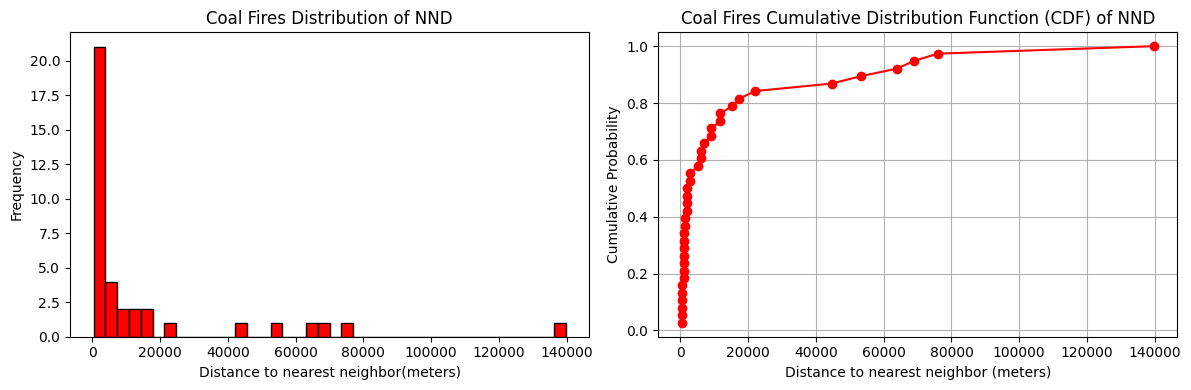

In [53]:
data = coal_fires
x = data.geometry.x
y = data.geometry.y

# Build a k-d tree from the point coordinates
tree = cKDTree(np.column_stack((x, y)))

# Query k-d tree to find nearest neighbors distances for each point
distances, indices = tree.query(np.column_stack((x, y)), k=2)  # k=2 for nearest neighbor

# Compute mean nearest neighbors distance
mean_distance = np.mean(distances[:, 1])  # distances[:, 1] contains distances to the nearest neighbor (excluding the point itself)
print("Mean nearest neighbors distance:", mean_distance)

plt.figure(figsize=(12, 4))# Visualize the distribution of nearest neighbors distances

# First subplot: histogram
plt.subplot(1, 2, 1)
plt.hist(distances[:, 1], bins=40, edgecolor='black', color='red')
plt.xlabel('Distance to nearest neighbor(meters)')
plt.ylabel('Frequency')
plt.title('Coal Fires Distribution of NND')

# Second subplot: CDF
plt.subplot(1, 2, 2)
sorted_distances = np.sort(distances[:, 1])
cdf = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances)
plt.plot(sorted_distances, cdf, color= 'red', marker='o', linestyle='-')
plt.xlabel('Distance to nearest neighbor (meters)')
plt.ylabel('Cumulative Probability')
plt.title('Coal Fires Cumulative Distribution Function (CDF) of NND')
plt.grid(True)

plt.subplots_adjust(wspace=10) # Add padding between subplots
plt.tight_layout()
plt.show()

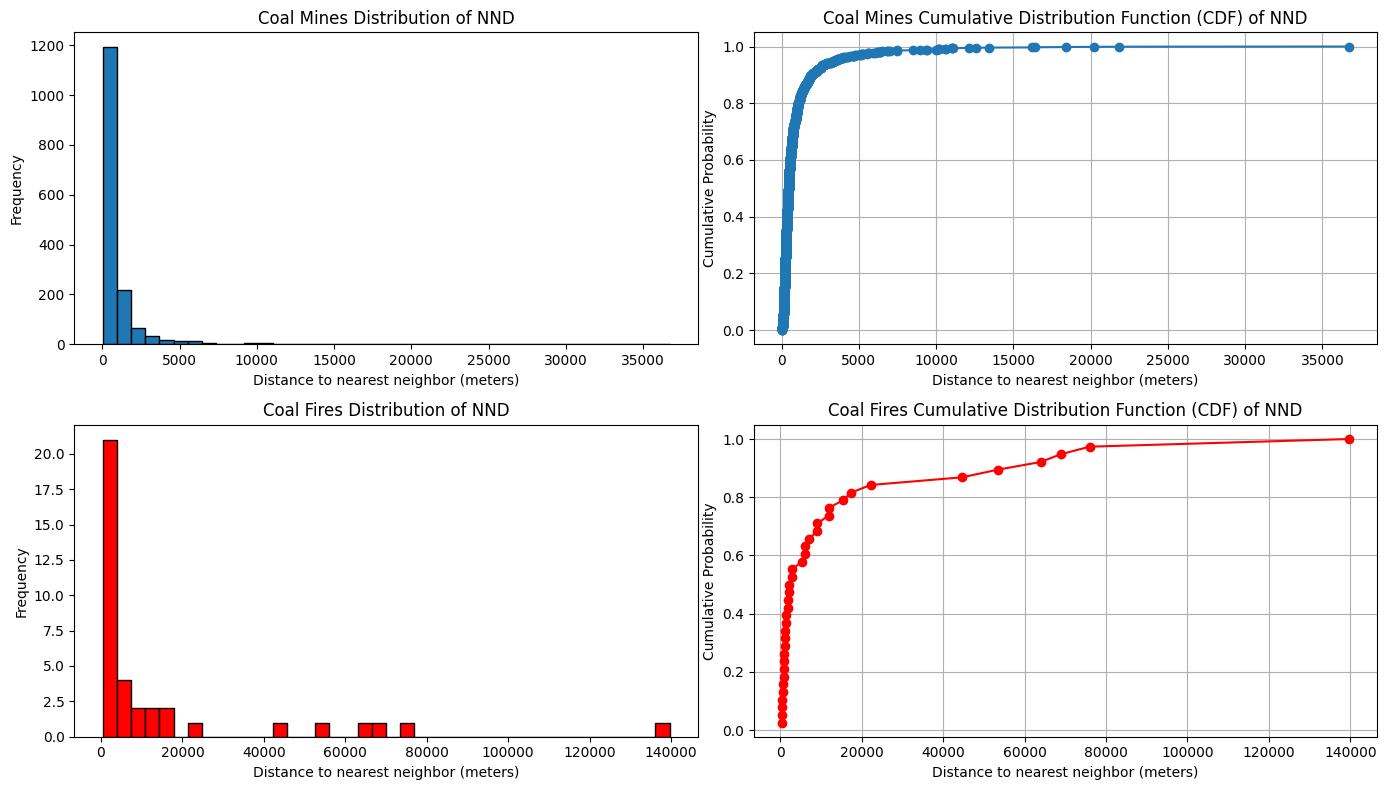

In [54]:
data_mines = coal_mines
x_mines = data_mines.geometry.x
y_mines = data_mines.geometry.y

# Build a k-d tree from the point coordinates for hogback_coal_mines
tree_mines = cKDTree(np.column_stack((x_mines, y_mines)))

# Query k-d tree to find nearest neighbors distances for each point for hogback_coal_mines
distances_mines, indices_mines = tree_mines.query(np.column_stack((x_mines, y_mines)), k=2)  # k=2 for nearest neighbor

# Compute mean nearest neighbors distance for hogback_coal_mines
mean_distance_mines = np.mean(distances_mines[:, 1])  # distances[:, 1] contains distances to the nearest neighbor (excluding the point itself)

data_fires = coal_fires
x_fires = data_fires.geometry.x
y_fires = data_fires.geometry.y

# Build a k-d tree from the point coordinates for hogback_coal_fires
tree_fires = cKDTree(np.column_stack((x_fires, y_fires)))

# Query k-d tree to find nearest neighbors distances for each point for hogback_coal_fires
distances_fires, indices_fires = tree_fires.query(np.column_stack((x_fires, y_fires)), k=2)  # k=2 for nearest neighbor

# Compute mean nearest neighbors distance for hogback_coal_fires
mean_distance_fires = np.mean(distances_fires[:, 1])  # distances[:, 1] contains distances to the nearest neighbor (excluding the point itself)

# Create a single figure with 4 subplots
plt.figure(figsize=(14, 8))

# Plot for hogback_coal_mines: histogram
plt.subplot(2, 2, 1)
plt.hist(distances_mines[:, 1], bins=40, edgecolor='black')
plt.xlabel('Distance to nearest neighbor (meters)')
plt.ylabel('Frequency')
plt.title('Coal Mines Distribution of NND')

# Plot for hogback_coal_mines: CDF
plt.subplot(2, 2, 2)
sorted_distances_mines = np.sort(distances_mines[:, 1])
cdf_mines = np.arange(1, len(sorted_distances_mines) + 1) / len(sorted_distances_mines)
plt.plot(sorted_distances_mines, cdf_mines, marker='o', linestyle='-')
plt.xlabel('Distance to nearest neighbor (meters)')
plt.ylabel('Cumulative Probability')
plt.title('Coal Mines Cumulative Distribution Function (CDF) of NND')
plt.grid(True)

# Plot for hogback_coal_fires: histogram
plt.subplot(2, 2, 3)
plt.hist(distances_fires[:, 1], bins=40, edgecolor='black', color='red')
plt.xlabel('Distance to nearest neighbor (meters)')
plt.ylabel('Frequency')
plt.title('Coal Fires Distribution of NND')

# Plot for hogback_coal_fires: CDF
plt.subplot(2, 2, 4)
sorted_distances_fires = np.sort(distances_fires[:, 1])
cdf_fires = np.arange(1, len(sorted_distances_fires) + 1) / len(sorted_distances_fires)
plt.plot(sorted_distances_fires, cdf_fires, color='red', marker='o', linestyle='-')
plt.xlabel('Distance to nearest neighbor (meters)')
plt.ylabel('Cumulative Probability')
plt.title('Coal Fires Cumulative Distribution Function (CDF) of NND')
plt.grid(True)

# Add padding between subplots
plt.subplots_adjust(wspace=12, hspace=20)

plt.tight_layout()
plt.show()

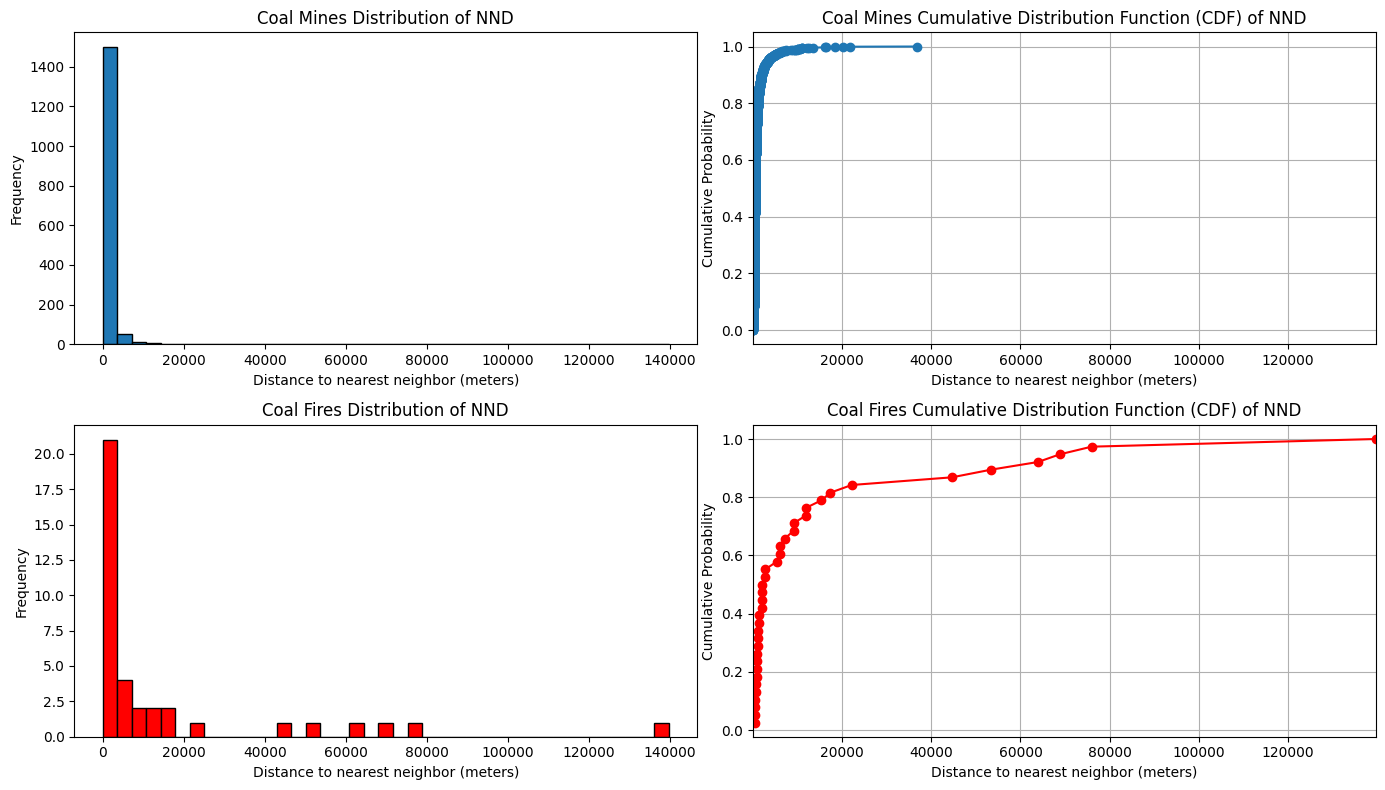

In [55]:
data_mines = coal_mines
x_mines = data_mines.geometry.x
y_mines = data_mines.geometry.y

# Build a k-d tree from the point coordinates for hogback_coal_mines
tree_mines = cKDTree(np.column_stack((x_mines, y_mines)))

# Query k-d tree to find nearest neighbors distances for each point for hogback_coal_mines
distances_mines, indices_mines = tree_mines.query(np.column_stack((x_mines, y_mines)), k=2)  # k=2 for nearest neighbor

# Compute mean nearest neighbors distance for hogback_coal_mines
mean_distance_mines = np.mean(distances_mines[:, 1])  # distances[:, 1] contains distances to the nearest neighbor (excluding the point itself)

# Extract coordinates for hogback_coal_fires
data_fires = coal_fires
x_fires = data_fires.geometry.x
y_fires = data_fires.geometry.y

# Build a k-d tree from the point coordinates for hogback_coal_fires
tree_fires = cKDTree(np.column_stack((x_fires, y_fires)))

# Query k-d tree to find nearest neighbors distances for each point for hogback_coal_fires
distances_fires, indices_fires = tree_fires.query(np.column_stack((x_fires, y_fires)), k=2)  # k=2 for nearest neighbor

# Compute mean nearest neighbors distance for hogback_coal_fires
mean_distance_fires = np.mean(distances_fires[:, 1])  # distances[:, 1] contains distances to the nearest neighbor (excluding the point itself)

# Determine common bin edges for both datasets
max_distance = max(np.max(distances_mines[:, 1]), np.max(distances_fires[:, 1]))
min_distance = min(np.min(distances_mines[:, 1]), np.min(distances_fires[:, 1]))
bin_edges = np.linspace(min_distance, max_distance, 40)  # Adjust the number of bins as needed

# Create a single figure with 4 subplots
plt.figure(figsize=(14, 8))

# Plot for hogback_coal_mines: histogram
plt.subplot(2, 2, 1)
plt.hist(distances_mines[:, 1], bins=bin_edges, edgecolor='black')
plt.xlabel('Distance to nearest neighbor (meters)')
plt.ylabel('Frequency')
plt.title('Coal Mines Distribution of NND')

# Plot for hogback_coal_mines: CDF
plt.subplot(2, 2, 2)
sorted_distances_mines = np.sort(distances_mines[:, 1])
cdf_mines = np.arange(1, len(sorted_distances_mines) + 1) / len(sorted_distances_mines)
plt.plot(sorted_distances_mines, cdf_mines, marker='o', linestyle='-')
plt.xlabel('Distance to nearest neighbor (meters)')
plt.ylabel('Cumulative Probability')
plt.title('Coal Mines Cumulative Distribution Function (CDF) of NND')
plt.grid(True)
plt.xlim(min_distance, max_distance)  # Set x-axis limits

# Plot for hogback_coal_fires: histogram
plt.subplot(2, 2, 3)
plt.hist(distances_fires[:, 1], bins=bin_edges, edgecolor='black', color='red')
plt.xlabel('Distance to nearest neighbor (meters)')
plt.ylabel('Frequency')
plt.title('Coal Fires Distribution of NND')

# Plot for hogback_coal_fires: CDF
plt.subplot(2, 2, 4)
sorted_distances_fires = np.sort(distances_fires[:, 1])
cdf_fires = np.arange(1, len(sorted_distances_fires) + 1) / len(sorted_distances_fires)
plt.plot(sorted_distances_fires, cdf_fires, color='red', marker='o', linestyle='-')
plt.xlabel('Distance to nearest neighbor (meters)')
plt.ylabel('Cumulative Probability')
plt.title('Coal Fires Cumulative Distribution Function (CDF) of NND')
plt.grid(True)
plt.xlim(min_distance, max_distance)  # Set x-axis limits

# Add padding between subplots
plt.subplots_adjust(wspace=12, hspace=20)

plt.tight_layout()
plt.show()

## Nearest Neighbor Distance Functions
Source: https://github.com/pysal/pointpats/blob/main/notebooks/distance_statistics-numpy-oriented.ipynb
<font size="2">

Nearest neighbour distance distribution functions (including the nearest “event-to-event” and “point-event” distance distribution functions) of a point process are cumulative distribution functions of several kinds -- $G, F, J$. By comparing the distance function of the observed point pattern with that of the point pattern from a CSR process, we are able to infer whether the underlying spatial process of the observed point pattern is CSR or not for a given confidence level.

#### $G$ funtion - event to event
The $G$ function is a kind of "cumulative" density describing the distribution of distances within a point pattern. For a given distance $d$, $G(d)$ is the proportion of nearest neighbor distances that are less than $d$. To express this, we first need to define the nearest neighbor distance, which is the smallest distance from each observation $i$ to some other observation $j$, where $j\neq i$:
    $$ min_{j\neq i}\\{d_{ij}\\} = d^*_i $$
    
With this, we can define the $G$ function as a cumulative density function:\n
     $$G(d) = \frac{1}{N}\sum_{i=1}^N \mathcal{I}(d^*_i < d)$$


where $\mathcal{I}(.)$ is an *indicator function* that is $1$ when the argument is true and is zero otherwise. In simple terms, $G(d)$ gives the percentage of of nearest neighbor distances ($d^*_i$) that are smaller than $d$; when $d$ is very small, $G(d)$ is close to zero. When $d$ is large, $G(d)$ approaches one.

Analytical results about $G$ are available assuming that the \"null\" process of locating points in the study area is completely spatially random. In a completely spatially random process, the $G(d)$ value should be:
    $$ G(d) = 1-e^{-\lambda \pi d^2}\ $$

Practically, we assess statistical significance for the $G(d)$ function using simulations, where a known spatially-random process is generated and then analyzed. This partially accounts for issues with irregularly-shaped study areas, where locations of points are constrained. 

In practice, we use the `ripley.g_test` function to conduct a test on the $G(d)$. It estimates a value of $G(d)$ for a set of values (called the `support`). 

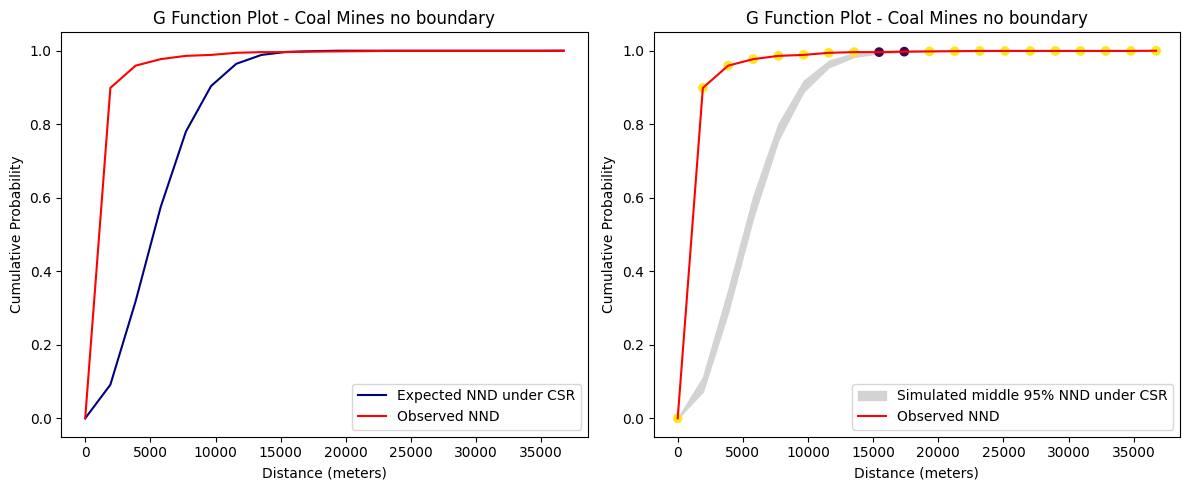

In [76]:
data = coal_mines
coords = np.column_stack((data.geometry.x, data.geometry.y))
g_test_result = pointpats.g_test(coords, keep_simulations=True)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for the first subplot
axes[0].plot(g_test_result.support, np.median(g_test_result.simulations, axis=0), color='navy', label='Expected NND under CSR')
axes[0].plot(g_test_result.support, g_test_result.statistic, color='red', label='Observed NND')
axes[0].legend()
axes[0].set_xlabel('Distance (meters)')
axes[0].set_ylabel('Cumulative Probability')
axes[0].set_title('G Function Plot - Coal Mines no boundary')

# Plot for the second subplot
# grab the middle 95% of simulations using numpy:
middle_95pct = np.percentile(g_test_result.simulations, q=(2.5, 97.5), axis=0)

# use the fill_between function to color between the 2.5% and 97.5% envelope
axes[1].fill_between(g_test_result.support, *middle_95pct, color='lightgrey', label='Simulated middle 95% NND under CSR')

# plot the line for the observed value of G(d)
axes[1].plot(g_test_result.support, g_test_result.statistic, color='red', label='Observed NND')

# and plot the support points depending on whether their p-value is smaller than .05
axes[1].scatter(g_test_result.support, g_test_result.statistic, cmap='viridis', c=g_test_result.pvalue < 0.01)
axes[1].legend()
axes[1].set_xlabel('Distance (meters)')
axes[1].set_ylabel('Cumulative Probability')
axes[1].set_title('G Function Plot - Coal Mines no boundary')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

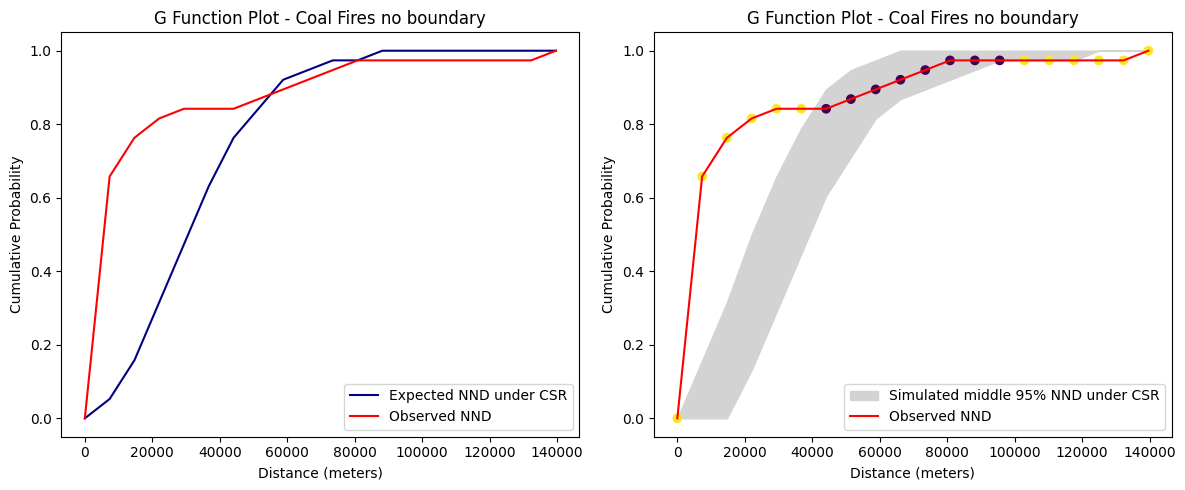

In [77]:
data = coal_fires
coords = np.column_stack((data.geometry.x, data.geometry.y))
g_test_result = pointpats.g_test(coords, keep_simulations=True)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for the first subplot
axes[0].plot(g_test_result.support, np.median(g_test_result.simulations, axis=0), color='navy', label='Expected NND under CSR')
axes[0].plot(g_test_result.support, g_test_result.statistic, color='red', label='Observed NND')
axes[0].legend()
axes[0].set_xlabel('Distance (meters)')
axes[0].set_ylabel('Cumulative Probability')
axes[0].set_title('G Function Plot - Coal Fires no boundary')

# Plot for the second subplot
# grab the middle 95% of simulations using numpy:
middle_95pct = np.percentile(g_test_result.simulations, q=(2.5, 97.5), axis=0)

# use the fill_between function to color between the 2.5% and 97.5% envelope
axes[1].fill_between(g_test_result.support, *middle_95pct, color='lightgrey', label='Simulated middle 95% NND under CSR')

# plot the line for the observed value of G(d)
axes[1].plot(g_test_result.support, g_test_result.statistic, color='red', label='Observed NND')

# and plot the support points depending on whether their p-value is smaller than .05
axes[1].scatter(g_test_result.support, g_test_result.statistic, cmap='viridis', c=g_test_result.pvalue < 0.01)
axes[1].legend()
axes[1].set_xlabel('Distance (meters)')
axes[1].set_ylabel('Cumulative Probability')
axes[1].set_title('G Function Plot - Coal Fires no boundary')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Generating CSR within the coal regions

           AREA      PERIMETER  COAL_REGIO  COAL_REG_1  GRID_CODE  \
1  8.274462e+09  635484.996507           3           0          0   
2  4.657869e+09  313713.089556           4           0          0   
3  2.763420e+09  503775.633420           5           0          0   
4  3.288186e+07   42861.833961           6           0          0   
5  7.652127e+06   15134.514463           7           0          0   

                 NAME                                           geometry  
1  Green River Region  POLYGON ((188307.317 4545385.725, 188667.977 4...  
2       Denver Region  POLYGON ((596292.212 4539582.198, 596291.084 4...  
3   North Park Region  POLYGON ((392553.462 4522099.032, 392638.056 4...  
4   North Park Region  POLYGON ((402345.253 4508507.296, 402260.649 4...  
5   North Park Region  POLYGON ((413302.640 4490227.838, 413217.523 4...  
Total coal region area:73678639748.34596


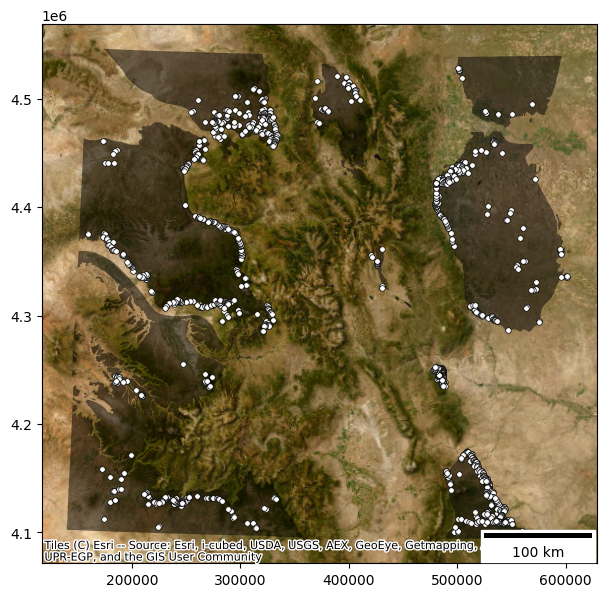

In [58]:
fig, ax = plt.subplots(figsize=(8, 7))

coal_regions.plot(ax=ax, color='black', alpha=0.5, label='Coal regions')
coal_mines.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5, markersize=16, label="Coal Mines")

ctx.add_basemap(ax=ax, crs=coal_mines.crs.to_string(), source=ctx.providers.Esri.WorldImagery)  
#plt.legend()
scalebar = ScaleBar(1, units='m', location='lower right')  # 1 pixel = 1 meter
ax.add_artist(scalebar)

print(coal_regions.head())
total = coal_regions['AREA'].sum()
print("Total coal region area:" + str(total))

In [59]:
from libpysal.cg import shapely_ext

### Attributes of PySAL Point Patterns
https://github.com/pysal/pointpats/blob/main/notebooks/process.ipynb

Point Pattern
1573 points
Bounding rectangle [(159534.83620645438,4094961.3164213076), (601149.400624143,4528616.837753252)]
Area of window: 74487053323.10446
Intensity estimate for window: 2.1117763823691027e-08
               x             y
0  535339.716879  4.126856e+06
1  486824.000627  4.237746e+06
2  531664.321722  4.126190e+06
3  226780.593551  4.128572e+06
4  311526.662328  4.108191e+06
Mean NND:970.3457564239693


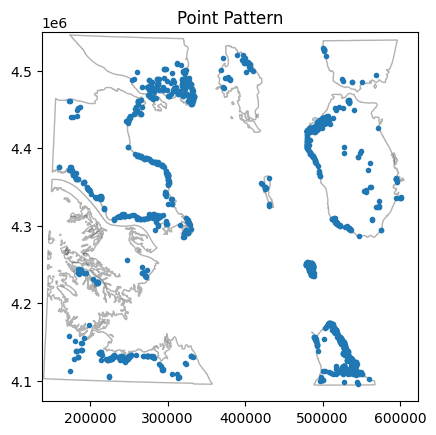

In [60]:
cu = shapely_ext.cascaded_union(coal_regions['geometry'])
window = Window(cu.parts)

data = coal_mines
# Create a PointPattern object from the coordinates
coords = np.column_stack((data.geometry.x, data.geometry.y))
pp = PointPattern(coords, window=window)

pp.summary()
#print("Number of Events:" + str(pp.n))
print("Mean NND:"+ str(pp.mean_nnd))
pp.plot(window=True)

Point Pattern
1573 points
Bounding rectangle [(159534.83620645438,4094961.3164213076), (601149.400624143,4528616.837753252)]
Area of window: 34969887810.13338
Intensity estimate for window: 4.498155694809478e-08
               x             y
0  535339.716879  4.126856e+06
1  486824.000627  4.237746e+06
2  531664.321722  4.126190e+06
3  226780.593551  4.128572e+06
4  311526.662328  4.108191e+06
Mean NND:970.3457564239693


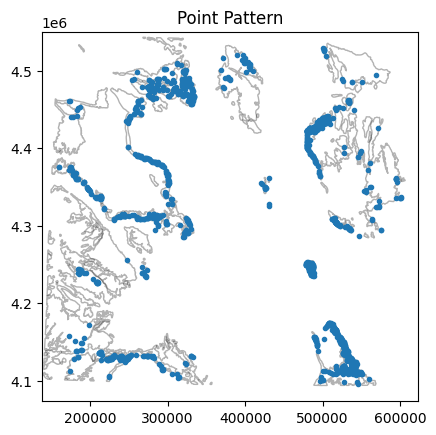

In [61]:
selected_buff = buffer[1500]
cu = shapely_ext.cascaded_union(selected_buff['geometry'])
window = Window(cu.parts)

data = coal_mines
# Create a PointPattern object from the coordinates
coords = np.column_stack((data.geometry.x, data.geometry.y))
pp = PointPattern(coords, window=window)

pp.summary()
#print("Number of Events:" + str(pp.n))
print("Mean NND:"+ str(pp.mean_nnd))
pp.plot(window=True)

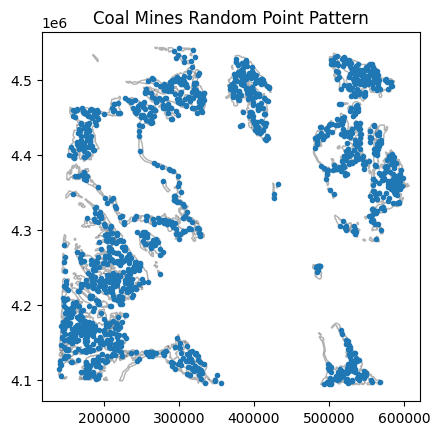

In [62]:
np.random.seed(5)
samples = PoissonPointProcess(window, pp.n, 2, conditioning=False, asPP=True) # simulate CSR 100 times
pp_csr = samples.realizations[0]
pp_csr.plot(window=True, title='Coal Mines Random Point Pattern')

np.random.seed(5)
xy_values = []
random = []

for _ in range(5):
    samples = PoissonPointProcess(window, pp.n, 1, conditioning=False, asPP=False)
    xy_values = (samples.realizations[0])
    points = ([Point(x, y) for x, y in xy_values])
    random.append(gpd.GeoDataFrame(geometry=points))

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))

coal_regions.plot(ax=ax, color='black', alpha=0.5, label='Coal-regions')

for i in range(len(1)):
    random[i].plot(ax=ax, markersize=1, label=f'CSR Sample {i+1}')
    
coal_mines.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5, markersize=16, label="Coal Mines")

ctx.add_basemap(ax=ax, crs=coal_mines.crs.to_string(), source=ctx.providers.Esri.WorldImagery)  
plt.legend()
scalebar = ScaleBar(1, units='m', location='lower right')  # 1 pixel = 1 meter
ax.add_artist(scalebar)

### Fixing the window
https://pysal.org/notebooks/explore/pointpats/window.html

In [71]:
union = shapely.coverage_union_all(coal_regions['geometry'])
type(union)

shapely.geometry.multipolygon.MultiPolygon

In [ ]:
data = coal_mines

coords = np.column_stack((data.geometry.x, data.geometry.y))
#g_test = pointpats.g_test(coords, keep_simulations=True, hull=union)
g_test = pointpats.g_test(coords, keep_simulations=False)
fig, ax = plt.subplots(figsize=(6, 4))

#Expected
#plt.plot(g_test.support, np.median(g_test.simulations, axis=0), color='navy', label = 'Expected NND under CSR')

#Observed
plt.plot(g_test.support, g_test.statistic, color='red', label='Observed')
y_limG = plt.ylim()
x_limG = plt.xlim()

plt.legend()
plt.xlabel('Distance (meters)')
plt.ylabel('Cumulative Probability')
plt.title('G Function Plot - Coal Mines')
plt.show()

coords read done
G test expected done


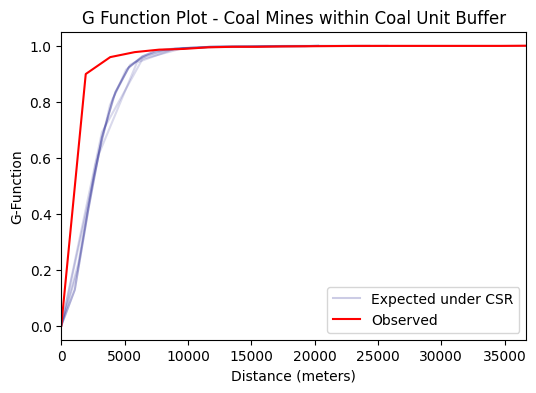

In [70]:
data = coal_mines

coords = np.column_stack((data.geometry.x, data.geometry.y))
print("coords read done")
#g_test = pointpats.g_test(coords, keep_simulations=False)
#print("G test expected done")

# Generate expected k-functions
#g_test_randoms = []
#for i in range(len(random)):
#    random_coords = np.column_stack((random[i].geometry.x, random[i].geometry.y))
#    g_test_random = pointpats.g_test(random_coords, keep_simulations=False)
#    g_test_randoms.append(g_test_random)
#    print("g_test_randoms done")

# Plot the expected K-functions
fig, ax = plt.subplots(figsize=(6, 4))
for i in range(len(random)):
    plt.plot(g_test_randoms[i].support, g_test_randoms[i].statistic, color='navy', alpha=0.15)
    
plt.plot(g_test_randoms[1].support, g_test_randoms[1].statistic, color='navy', alpha=0.2, label = 'Expected under CSR')

#Observed
plt.plot(g_test.support, g_test.statistic, color='red', label='Observed')

# Limit x-axis to the observed line distance
plt.xlim(min(g_test.support), max(g_test.support))
#plt.ylim(y_lim)

plt.legend()
plt.xlabel('Distance (meters)')
plt.ylabel('G-Function')
plt.title('G Function Plot - Coal Mines within Coal Unit Buffer (1500ft)')
plt.show()

Point Pattern
38 points
Bounding rectangle [(176427.7391285773,4098801.9742000033), (543801.1403228304,4490982.999857532)]
Area of window: 34969887810.13338
Intensity estimate for window: 1.0866491824714569e-09
               x             y
0  543801.140323  4.098802e+06
1  275462.999874  4.478771e+06
2  485296.000040  4.238513e+06
3  378104.000004  4.490983e+06
4  480405.488093  4.422755e+06
Mean NND:15646.566993672119
Point Pattern
38 points
Bounding rectangle [(144329.6168004832,4094609.4631193173), (577675.5014013074,4537037.248113491)]
Area of window: 34969887810.13338
Intensity estimate for window: 1.0866491824714569e-09
               x             y
0  367739.821732  4.484888e+06
1  497247.267636  4.094609e+06
2  227408.087046  4.272936e+06
3  177480.635720  4.459379e+06
4  550464.581198  4.106700e+06


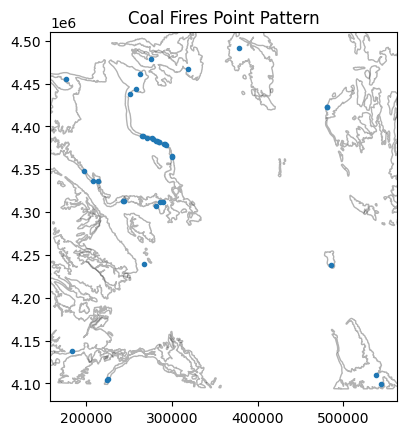

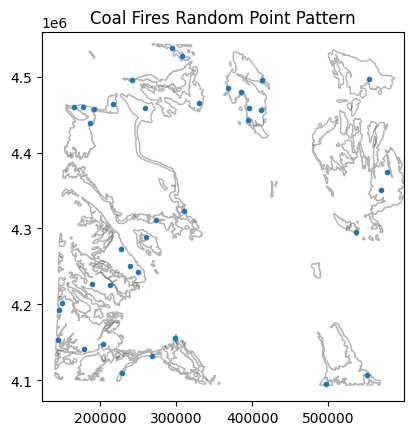

In [177]:
selected_buff = buffer[1500]
cu = shapely_ext.cascaded_union(selected_buff['geometry'])
window = Window(cu.parts)

data = coal_fires
coords = np.column_stack((data.geometry.x, data.geometry.y))
ppf = PointPattern(coords, window=window)

ppf.summary()
print("Mean NND:"+ str(ppf.mean_nnd))
ppf.plot(window=True, title='Coal Fires Point Pattern')

np.random.seed(5)
samples = PoissonPointProcess(window, ppf.n, 4, conditioning=False, asPP=True) # simulate CSR 100 times
ppf_csr = samples.realizations[0]
ppf_csr.summary()
ppf_csr.plot(window=True, title='Coal Fires Random Point Pattern')

In [178]:
np.random.seed(5)
xy_values = []
randomf = []

for _ in range(10):
    samples = PoissonPointProcess(window, ppf.n, 2, conditioning=False, asPP=False)
    xy_values = (samples.realizations[0])
    points = ([Point(x, y) for x, y in xy_values])
    randomf.append(gpd.GeoDataFrame(geometry=points))

coords read done
G test expected done
g_test_randoms done
g_test_randoms done
g_test_randoms done
g_test_randoms done
g_test_randoms done
g_test_randoms done
g_test_randoms done
g_test_randoms done
g_test_randoms done
g_test_randoms done


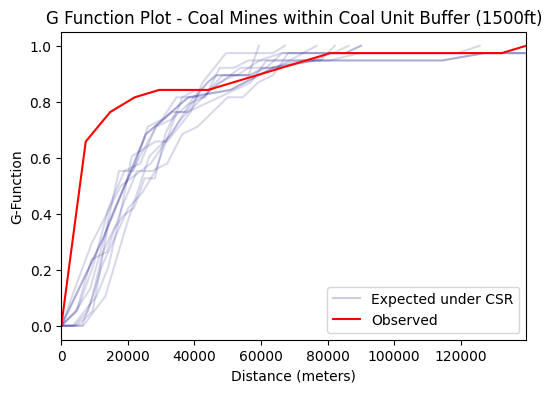

In [179]:
data = coal_fires

coords = np.column_stack((data.geometry.x, data.geometry.y))
print("coords read done")
g_test_f = pointpats.g_test(coords, keep_simulations=False)
print("G test expected done")

# Generate expected g-functions
g_test_randoms_f = []
for i in range(len(randomf)):
    random_coords = np.column_stack((randomf[i].geometry.x, randomf[i].geometry.y))
    g_test_random = pointpats.g_test(random_coords, keep_simulations=False)
    g_test_randoms_f.append(g_test_random)
    print("g_test_randoms done")

# Plot the expected K-functions
fig, ax = plt.subplots(figsize=(6, 4))
for i in range(len(randomf)):
    plt.plot(g_test_randoms_f[i].support, g_test_randoms_f[i].statistic, color='navy', alpha=0.15)
    
plt.plot(g_test_randoms_f[1].support, g_test_randoms_f[1].statistic, color='navy', alpha=0.2, label = 'Expected under CSR')

#Observed
plt.plot(g_test_f.support, g_test_f.statistic, color='red', label='Observed')

# Limit x-axis to the observed line distance
plt.xlim(min(g_test_f.support), max(g_test_f.support))

plt.legend()
plt.xlabel('Distance (meters)')
plt.ylabel('G-Function')
plt.title('G Function Plot - Coal Mines within Coal Unit Buffer (1500ft)')
plt.show()

In [ ]:
# Data for the first plot
data = coal_mines
coords = np.column_stack((data.geometry.x, data.geometry.y))
g_test_result = pointpats.g_test(coords, keep_simulations=True, hull=union)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot for the first subplot
axes[0].plot(g_test_result.support, np.median(g_test_result.simulations, axis=0), color='navy', label='Expected NND under CSR')
axes[0].plot(g_test_result.support, g_test_result.statistic, color='red', label='Observed NND')
axes[0].legend()
axes[0].set_xlabel('Distance (meters)')
axes[0].set_ylabel('Cumulative Probability')
axes[0].set_title('G Function Plot - Coal Mines')

# Plot for the second subplot
# grab the middle 95% of simulations using numpy:
middle_95pct = np.percentile(g_test_result.simulations, q=(2.5, 97.5), axis=0)

# use the fill_between function to color between the 2.5% and 97.5% envelope
axes[1].fill_between(g_test_result.support, *middle_95pct, color='lightgrey', label='Simulated middle 95% NND under CSR')

# plot the line for the observed value of G(d)
axes[1].plot(g_test_result.support, g_test_result.statistic, color='red', label='Observed NND')

# and plot the support points depending on whether their p-value is smaller than .05
axes[1].scatter(g_test_result.support, g_test_result.statistic, cmap='viridis', c=g_test_result.pvalue < 0.01)
axes[1].legend()
axes[1].set_xlabel('Distance (meters)')
axes[1].set_ylabel('Cumulative Probability')
axes[1].set_title('G Function Plot - Coal Mines')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

From this, we can see that there is statistically significant "dispersion" at small values of $d$, since there are too many nearest neighbor distances observed between $0<d<2700$
. Once we get to very large distances, the simulation envelope covers the observed statistic. As such, we can say that the point pattern recorded in points is unusally dispersed.

## Interevent Distance Functions

While both the $F(d)$ and $G(d)$ functions are useful, they only consider the distance between each point $i$ and its nearest point. Earlier we spelled this distance $d_i^*$, and the distance between $i$ and $j$ was $d_{ij}$. So, note that $d_{i}^*$ is the *only* term that matters for $F$ and $G$, if $d_{ij}$ changes (but $j$ isn't closest to $i$), then the $F$ and $G$ functions generally remain the same.

So, further statistical summary functions have been developed to consider the *whole* distance distribution, not only the nearest neighbor distances. These functions (still considered part of the \"Ripley\" alphabet, are the $K$, and $L$ functions.

## $K$ function
The $K(d)$ function is a scaled version of the cumulative density function for *all* distances within a point pattern. As such, it's a \"relative\" of the $G$ function that considers all distances, not just the nearest neighbor distances. Practically, the $K(d)$ function can be thought of as the percentage of all distances that are less than $d$. Therefore, for a threshold distance $d$, the $K$ function is defined as:
    $$K(d) = \frac{1}{N\hat\lambda} \underset{i=1}{\overset{N}{\sum}}\underset{j=1}{\overset{N}{\sum}} \mathcal{I}\left(d_ij < d\right)$$
    

In this equation, $\hat\lambda$ is the *intensity* of the point process. This represents how many points (on average) you would expect in a unit area. You can think of this as an analogue to the *density* of the points in the pattern: large values of $\hat\lambda$ mean many points per area, and small values of $\hat\lambda$ mean there are fewer points per area. Generally, this parameter is unknown, and is modelled using the average number of points in the study area. This assumes that the intensity of the point pattern is *constant* or *homogeneous* over the study area.

In the same manner as before, we can construct a set of $K(d)$ function evaluations for random point patterns, and compare them to the observed $K(d)$ function we saw in our original data.

In [ ]:
data = coal_mines

coords = np.column_stack((data.geometry.x, data.geometry.y))
k_test = pointpats.k_test(coords, keep_simulations=True, hull=union)
print("k done")

fig, ax = plt.subplots(figsize=(6, 4))
#Expected
plt.plot(k_test.support, k_test.simulations.T, color='navy', alpha=.01, label = 'Expected under CSR')

#Observed
plt.plot(k_test.support, k_test.statistic, color='red', label='Observed')

#plt.legend()
plt.ylabel('K Function')
plt.xlabel('Distance (meters)')
plt.title('K Function Plot - Coal Mines')
plt.show()

coords read
K test
k_test_randoms done
k_test_randoms done
k_test_randoms done
k_test_randoms done
k_test_randoms done


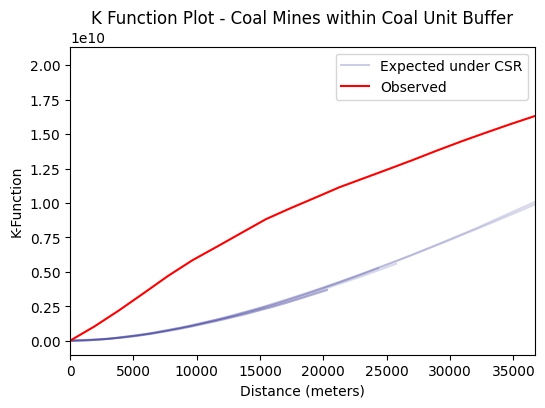

In [75]:
data = coal_mines

coords = np.column_stack((data.geometry.x, data.geometry.y))
print("coords read")
k_test = pointpats.k_test(coords, keep_simulations=False)
print("K test")

# Generate expected k-functions
k_test_randoms = []
for i in range(len(random)):
    random_coords = np.column_stack((random[i].geometry.x, random[i].geometry.y))
    k_test_random = pointpats.k_test(random_coords, keep_simulations=False)
    k_test_randoms.append(k_test_random)
    print("k_test_randoms done")

# Plot the expected K-functions
fig, ax = plt.subplots(figsize=(6, 4))
for i in range(len(random)):
    plt.plot(k_test_randoms[i].support, k_test_randoms[i].statistic, color='navy', alpha=0.15)
    
plt.plot(k_test_randoms[1].support, k_test_randoms[1].statistic, color='navy', alpha=0.2, label = 'Expected under CSR')

#Observed
plt.plot(k_test.support, k_test.statistic, color='red', label='Observed')

# Limit x-axis to the observed line distance
plt.xlim(min(k_test.support), max(k_test.support))
#plt.ylim(y_lim)

plt.legend()
plt.xlabel('Distance (meters)')
plt.ylabel('K-Function')
plt.title('K Function Plot - Coal Mines within Coal Unit Buffer')
plt.show()

## $L$ function - \"interevent\"
The $L$ function is a scaled version of $K$ function, defined in order to assist with interpretation. The expected value of the $K(d)$ function *increases* with $d$; this makes sense, since the number of pairs of points closer than $d$ will increase as $d$ increases. So, we can define a normalization of $K$ that *removes* this increase as $d$ increases.
    $$L(d) = \sqrt{\frac{K(d)}{\pi}}-d$$

For a pattern that is spatially random, $L(d)$ is $0$ at all $d$ values. So, we can use this standardization to make it easier to visualize the results of the $K$ function:  

In [ ]:
data = coal_mines
coords = np.column_stack((data.geometry.x, data.geometry.y))

l_test = pointpats.l_test(coords, keep_simulations=True, hull=union)

#Expected
plt.plot(l_test.support, l_test.simulations.T, color='navy', alpha=.01, label = 'Expected under CSR')

#Observed
plt.plot(l_test.support, l_test.statistic, color='red', label='Observed')

#plt.legend()
plt.ylabel('L Function')
plt.xlabel('Distance (meters)')
plt.title('L Function Plot - Coal Mines')
plt.show()

In [ ]:
data = coal_mines
coords = np.column_stack((data.geometry.x, data.geometry.y))

l_test = pointpats.l_test(coords, keep_simulations=False)

l_test_randoms = []
for i in range(len(random)):
    random_coords = np.column_stack((random[i].geometry.x, random[i].geometry.y))
    l_test_random = pointpats.l_test(random_coords, keep_simulations=False)
    l_test_randoms.append(l_test_random)

# Plot the expected K-functions
fig, ax = plt.subplots(figsize=(6, 4))
for i in range(len(random)):
    plt.plot(l_test_randoms[i].support, l_test_randoms[i].statistic, color='navy', alpha=0.15)
    
plt.plot(l_test_randoms[1].support, l_test_randoms[1].statistic, color='navy', alpha=0.2, label = 'Expected under CSR')

#Observed
plt.plot(l_test.support, l_test.statistic, color='red', label='Observed')
plt.xlim(min(l_test.support), max(l_test.support))

plt.legend()
plt.ylabel('L Function')
plt.xlabel('Distance (meters)')
plt.title('L Function Plot - Coal Mines within Coal Units Buffer')
plt.show()

# Intensity

In [ ]:
pp_nnd=pp.nnd
pp_nnd
variance = np.var(pp_nnd)
print("Variance:", variance)
mean

##  Quadrat Statistic

In the previous notebooks, we introduced the concept of Complete Spatial Randomness (CSR) process which serves as the benchmark process. Utilizing CSR properties, we can discriminate those that are not from a CSR process. Quadrat statistic is one such method. Since a CSR process has two major characteristics:
1. Uniform: each location has equal probability of getting a point (where an event happens).
2. Independent: location of event points are independent.

We can imagine that for any point pattern, if the underlying process is a CSR process, the expected point counts inside any cell of area $|A|$ should be $\lambda |A|$ ($\lambda$ is the intensity which is uniform across the study area for a CSR). Thus, if we impose a $m \times k$ rectangular tessellation over the study area (window), we can easily calculate the expected number of points inside each cell under the null of CSR. By comparing the observed point counts against the expected counts and calculate a $\chi^2$ test statistic, we can decide whether to reject the null based on the position of the $\chi^2$ test statistic in the sampling distribution. 

$$\chi^2 = \sum^m_{i=1} \sum^k_{j=1} \frac{[x_{i,j}-E(x_{i,j})]^2}{\lambda |A_{i,j}|}$$

There are two ways to construct the sampling distribution and acquire a p-value:
1. Analytical sampling distribution: a $\chi^2$ distribution of $m \times k -1$ degree of freedom. We can refer to the $\chi^2$ distribution table to acquire the p-value. If it is smaller than $0.05$, we will reject the null at the $95\%$ confidence level.
2. Empirical sampling distribution: a distribution constructed from a large number of $\chi^2$ test statistics for  simulations under the null of CSR. If the $\chi^2$ test statistic for the observed point pattern is among the largest $5%$ test statistics, we would say that it is very unlikely that it is the outcome of a CSR process at the $95\%$ confidence level. Then, the null is rejected. A pseudo p-value can be calculated based on which we can use the same rule as p-value to make the decision:
$$p(\chi^2) = \frac{1+\sum^{nsim}_{i=1}\phi_i}{nsim+1}$$
where 
$$ 
\phi_i =
 \begin{cases}
    1       & \quad \text{if } \psi_i^2 \geq \chi^2 \\
    0       & \quad \text{otherwise } \\
  \end{cases}
$$

$nsim$ is the number of simulations, $\psi_i^2$ is the $\chi^2$ test statistic calculated for each simulated point pattern, $\chi^2$ is the $\chi^2$ test statistic calculated for the observed point pattern, $\phi_i$ is an indicator variable.

We are going to introduce how to use the **quadrat_statistics.py** module to perform quadrat based method using either of the above two approaches to constructing the sampling distribution and acquire a p-value.

In [ ]:
import pointpats.quadrat_statistics as qs
qstat = qs.QStatistic(pp, shape= "rectangle", nx = 10, ny = 10)
qstat.plot()
qstat.chi2_pvalue